In [1]:
import numpy as np
import pandas as pd
import re
import datetime
import math
from matplotlib import pyplot as plt
from functools import partial
from scipy.optimize import least_squares
from scipy.integrate import odeint

In [2]:
df = pd.read_csv('project10_data.csv')
df

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,1/7/23,1/8/23,1/9/23,1/10/23,1/11/23,1/12/23,1/13/23,1/14/23,1/15/23,1/16/23
0,84006075,US,USA,840,6075,San Francisco,California,US,37.752151,-122.438567,...,203871,203871,203871,204696,204696,204696,204806,204806,204806,204806
1,84006075,US,USA,840,6075,San Francisco,California,US,37.752151,-122.438567,...,1114,1114,1114,1114,1116,1123,1129,1137,1137,1137


# Exercise 1: Fit a SI Model

## Question (1) 
Load your assigned data as a vector $v = (v(t))$. Identify the first time (date) $t0$ when $v(t0) ≥ 5$, that is, the number of detected cases is at least 5. That time represents the starting time in your simulation. Print $t0$.

In [3]:
# Initialize the max
tmax = 119

# First to clean the table with only the time series data
col_list = []
for col in df.columns:
    if re.search("^[0-9]+", col):
        col_list.append(col)

# df_clean symbolizing all dates with given data
df_clean = df[col_list]
df_clean.columns = pd.to_datetime(df_clean.columns, format="%m/%d/%y")
df_clean
# df_clean

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2023-01-07,2023-01-08,2023-01-09,2023-01-10,2023-01-11,2023-01-12,2023-01-13,2023-01-14,2023-01-15,2023-01-16
0,0,0,0,0,0,0,0,0,0,0,...,203871,203871,203871,204696,204696,204696,204806,204806,204806,204806
1,0,0,0,0,0,0,0,0,0,0,...,1114,1114,1114,1114,1116,1123,1129,1137,1137,1137


In [4]:
# find t0 as the starting time for the simulation
for i in range(len(df_clean.columns)):
    if df_clean.iloc[0, i] >= 5:
        t0 = i
        break
    
print(t0)
print(df_clean.columns[i].date())

45
2020-03-07


Therefore, we find that the t0 happens at t=45, which is 03/07/2020.

## Question (2) 
Let $I(t) = v(t+t0)$, for $0 ≤ t ≤ T_{max}$. In otherwords create a vector of length $T_{max} + 1$ days of daily infection rates starting from the date at least 5 infections hae been detected. Let $N_{max}$ denote this county population. Denote by $N_{min} = 1 + I(T_{max})$ the maximum infected population based your data.

### (2)(a) Implement Algorithm "SI Alg 1 - known N"
Run this algorithm for $N = N_{min}$ and $N = N_{max}$, and for each of the two values of N:

In [5]:
# Get population
population = df["Population"][0]

infection_list = list(df_clean.iloc[0])
I = infection_list[t0:(t0+tmax+1)]

N_max_a = population
N_min_a = 1 + I[-1]

print(f"N_max = {N_max_a}, N_min = {N_min_a}") 

N_max = 881549, N_min = 3863


### (2)(a)(i) 
Print the estimated $β = \hat{β}$ and the value of objective function $J(β, N)$.

### (2)(a)(ii) 
Plot in the same figure $I(t)$ and the predicted value of the infection count based on the SI model, i.e. $NI(0)/(I(0) + (N − I(0))e^{−βt})$.

In [6]:
def jacobian(I, beta, N):
    J = 0
    for t in range(0, tmax+1):
        J += math.pow(abs((beta * t - math.log(I[t] / (N - I[t])) + math.log(I[0] / (N - I[0])))), 2)
        
    return J

Running for N = 3863
Estimated: beta = beta_hat = 0.08334705622094742
The value of objective function J(beta, N) is 200.6980201521093
--------------------
Running for N = 881549
Estimated: beta = beta_hat = 0.06786369732468558
The value of objective function J(beta, N) is 249.05070249950745
--------------------


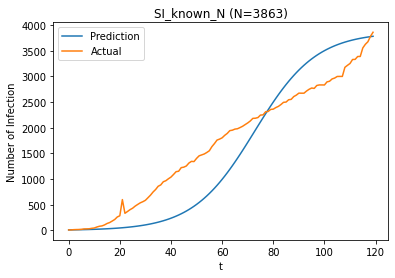

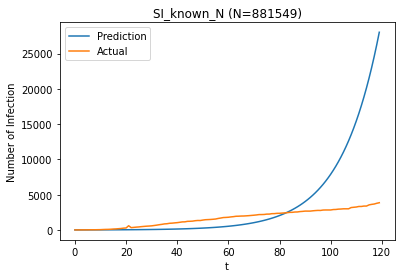

In [7]:
for N_a in [N_min_a, N_max_a]:
    print(f"Running for N = {N_a}")

    temp = 0
    for t in range(1, tmax+1):
        temp += t * math.log((I[t] / I[0]) * ((N_a - I[0]) / (N_a - I[t])))
    step = 6 / (tmax * (tmax + 1) * (2 * tmax + 1))
    beta_hat_a = step * temp

    print(f"Estimated: beta = beta_hat = {beta_hat_a}")

    J_a = jacobian(I, beta_hat_a, N_a)
    print(f"The value of objective function J(beta, N) is {J_a}")

    tlist = np.arange(0, tmax+1)
    I_func_1 = [N_a * I[0] / (I[0] + (N_a - I[0]) * math.exp(-beta_hat_a * t)) for t in tlist]
    plt.figure()
    plt.plot(I_func_1, label="Prediction")
    plt.plot(I, label="Actual")
    plt.xlabel("t")
    plt.ylabel("Number of Infection")
    plt.title(f"SI_known_N (N={N_a})")
    plt.legend()
    print("-" * 20)

## (2)(b) Implement Algorithm "SI Alg 2 - Unknown N"

### (2)(b)(i) 
Save intermediate values of $J(N)$ computed at step 2.1. Plot the graph $J = J(N)$ of these intermedate results.

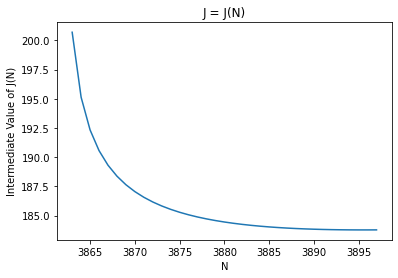

In [8]:
# Initialize data
N_b = N_min_a
J_old = math.inf
a = step

total_J = []
track_N = []
J_b = 0

while True:
    temp1 = 0
    for t in range(1, tmax+1):
        temp1 += math.pow(abs(math.log((I[t] / I[0]) * ((N_b - I[0]) / (N_b - I[t])))), 2)
    
    temp2 = 0
    for t in range(1, tmax+1):
        temp2 += t * math.log((I[t] / I[0]) * ((N_b - I[0]) / (N_b - I[t])))

    J_b = temp1 - a * math.pow(temp2, 2)
    total_J.append(J_b)
    track_N.append(N_b)

    if J_b < J_old:
        J_old = J_b
        N_b += 1
    else:
        break

plt.plot(track_N, total_J)
plt.xlabel("N")
plt.ylabel("Intermediate Value of J(N)")
plt.title("J = J(N)")
plt.show()

### (2)(b)(ii)
Print the estimates $N = \hat{N}$ and $β = \hat{β}$ as well as the value of objective function $J(β, N)$.

In [9]:
# N_hat is the last N
N_hat = track_N[-1]

temp3 = 0
for t in range(1, tmax+1):
    temp3 += t * math.log((I[t] / I[0]) * ((N_hat - I[0]) / (N_hat - I[t])))
beta_hat_b = a * temp3

print(f"The estimates N = N_hat = {N_hat}")
print(f"beta = beta_hat = {beta_hat_b}") 
# J = J(N) is the last J value 
print(f"the value of objective function J(beta, N) = {J_b}")

The estimates N = N_hat = 3897
beta = beta_hat = 0.08225041206859607
the value of objective function J(beta, N) = 183.78238465282857


### (2)(b)(iii)
Plot in the same figure $I(t)$ and the predicted value of the infection count based on the SI model, i.e. $NI(0)/(I(0) + (N − I(0))e^{−βt})$ at the stopping value of $N$.

--------------------


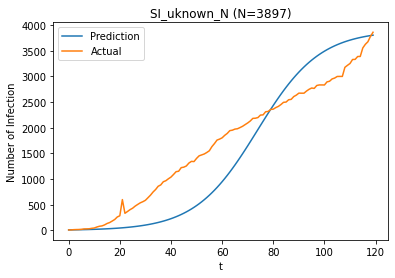

In [10]:
I_func_2 = [N_hat * I[0] / (I[0] + (N_hat - I[0]) * math.exp(-beta_hat_b * t)) for t in tlist]
plt.figure()
plt.plot(I_func_2, label="Prediction")
plt.plot(I, label="Actual")
plt.xlabel("t")
plt.ylabel("Number of Infection")
plt.title(f"SI_uknown_N (N={N_hat})")
plt.legend()
print("-" * 20)

### (2)(b)(iv)
Can you run step 2.1 for all values of $N$ from $N_{min}$ to $N_{max}$ estimated before? If so, plot $J = J(N)$ and determine the global minimum on this interval. Does it differ from part (b.ii)?

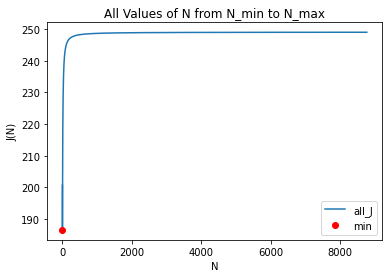

In [11]:
N_min_b = N_min_a
N_max_b = population
a = step

all_J = []

for N_b_2 in range(N_min_a, N_max_a, 100):
    sum1 = 0
    for t in range(1, tmax+1):
        sum1 += math.pow(abs(math.log((I[t] / I[0]) * ((N_b_2 - I[0]) / (N_b_2 - I[t])))), 2)
    
    sum2 = 0
    for t in range(1, tmax+1):
        sum2 += t * math.log((I[t] / I[0]) * ((N_b_2 - I[0]) / (N_b_2 - I[t])))

    J_bfour = sum1 - a * math.pow(sum2, 2)
    all_J.append(J_bfour)

plt.figure()
plt.plot(all_J, label="all_J")
plt.plot(np.argmin(all_J), np.min(all_J), 'ro', label="min")
plt.legend()
plt.xlabel("N")
plt.ylabel("J(N)")
plt.title("All Values of N from N_min to N_max")
plt.show()

By the graph above, we conclude that the graph is totally different from the graph in part (2)(b)(ii). The minimum is at the beginning of the plot.

## (2)(c) Implement new algorithm
Implement the following algorithm: For each value of $N$ consdered at part (2.b), compute the optimal $β(N) = \hat{β}$ according to Algorithm SI Alg 1 - Known N, and then compute the “ideal” objective function $I(N, β(N))$ displayed at the bottom of slide “How to Calibrate SI Models”. Plot the function $N \rightarrow I(N, β(N))$ and determine its minimum. Does it match your findings at part (b.ii)?

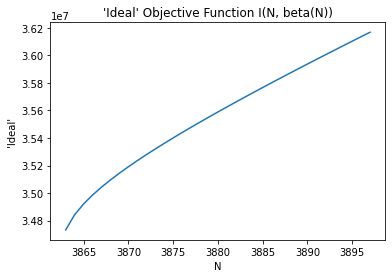

In [12]:
total_J_c = []

for N_c in track_N:
    # Find optimal beta for every N
    temp4 = 0
    for t in range(1, tmax+1):
        temp4 += t * math.log((I[t] / I[0]) * ((N_c - I[0]) / (N_c - I[t])))

    beta_hat_c = step * temp4

    # Compute the "ideal" objective function I(N, beta(N))
    temp5 = 0
    for t in range(0, tmax+1):
        temp5 += math.pow(abs(I[t] - N_c * I[0] / (I[0] + (N_c - I[0]) * math.exp(-beta_hat_c * t))), 2)

    J_c = temp5

    total_J_c.append(J_c)

plt.plot(track_N, total_J_c)
plt.xlabel("N")
plt.ylabel("'Ideal'")
plt.title("'Ideal' Objective Function I(N, beta(N))")
plt.show()

In [13]:
minimum_ideal_function = total_J_c[0]
print(minimum_ideal_function)

34732650.09149592


From the above graph after we plot the "ideal" objective function I(N, beta(N)), we conclude that the "ideal" objective function is increasing with the increase of N (the number of cumulative detected infections). By the trend from the observation, we conclude that the minimum of the "ideal" objective function happens at the minimum of N, which is 34732650.09149592.
<br><br>
In conclusion, the finding in part(c) does not match with the findsing at part(b.ii) because the optimal in part(b.ii) is at the maximum N in the dataset, but the optimal in part(c) is at the minimum N in the dataset.

# Exercise 2
## Question (1)
Create the rates of active infection $I(t)$ using a difference formula: $I(t) = v(t + t_0 + τ) −v(t + t_0 − τ)$, for $0 ≤ t ≤ T_{max}$. The parameter τ is related to incubation and infection period. Set $τ = 7$ days for now (the assumption is that the infection lasts up to 14 days). Plot $I = I(t)$, the rates of active infection.

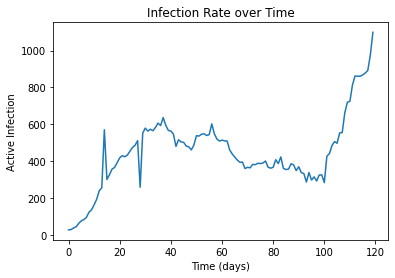

In [14]:
# Get population
population = df["Population"][0]
accumulated_cases = np.array(df_clean.iloc[0])

T_max = 119
I = np.zeros(T_max + 1)

for t in range(0, T_max + 1):
    I[t] = accumulated_cases[t + t0 + 7] - accumulated_cases[t + t0 -7]


plt.figure()
plt.plot(I)
plt.xlabel("Time (days)")
plt.ylabel("Active Infection")
plt.title("Infection Rate over Time")
plt.show()

## Question (2)
Implement an Euler scheme for solving the SIR Model with step size h = 0.01. Denote by $(S_{sim}(t),I_{sim}(t),R_{sim}(t))$ the numerical solution. Use initialization S(0) = N, I(0) from the data set, $R(0) = 0$. For this problem, the unknown parameters are $α,β,N$.

In [15]:
def SIR_simulation(x, return_all=False):
    alpha, beta, N = x
    y_0 = [N-I[0], I[0], 0]  # Susceptible, Infected, Recovered
    T = 0.01

    results = [
        y_0,
    ]

    # Euler method
    for t in np.arange(start=1, stop=T_max+1, step=0.01):
        y_0 = [
            y_0[0] - beta * y_0[0] * y_0[1]/N * T,
            y_0[1] + beta * y_0[0] * y_0[1]/N * T- alpha * y_0[1] * T,
            y_0[2] + alpha * y_0[1] * T
        ]
        results.append(y_0)
    
    results = np.array(results)
    results = results[::100]

    if return_all:
        return results[:, 0], results[:, 1], results[:, 2]
    
    return I - results[:, 1]

## Question (3)
For each combination $(α,β,N)$ in the set Ω described below repeat: 

So let's calculate all possible Ω first.

### (3)(a)
Run your numerical solver and produce $I_{sim}= (I_{sim}(t))$.

In [16]:
omegas = []

for alpha in [1 / 10, 1 / 9, 1 / 8, 1 / 7, 1 / 6, 1 / 5]:
    for R0 in [0.8, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2, 1.3, 1.4, 1.5, 1.6]:
        for N in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            N_max = population * N
            omegas.append((alpha, R0 * alpha, R0, N_max))

### (3)(b)
Compute the $l^2$-norm squared of the residuals and save it in an array indexed by the three parameters:

In [17]:
from tqdm import tqdm

results = []
for alpha, beta, R0, N_max in tqdm(omegas):
    S, I_hat, R = SIR_simulation((alpha, beta, N_max), return_all=True)
    J = np.sqrt(np.sum((I - I_hat) ** 2))
    results.append((alpha, beta, R0, N_max, J))

results = np.array(results)

100%|██████████| 720/720 [00:18<00:00, 39.76it/s]


## Question (4)
Visualize the function J by plotting two-dimensional surfaces $(β,N) → J(α,β,N)$ for each value of $α$. In particular determine where the minimum of this function occurs (over the finite set of values considered above).

Optimal Solution: alpha=0.16666666666666666, beta=0.19999999999999998, R0=1.2, N=88154.90000000001


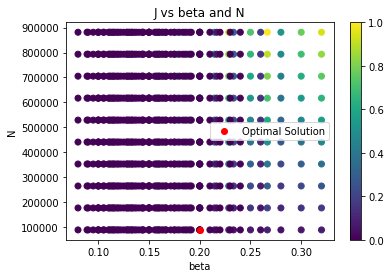

In [18]:
plt.figure()
plt.scatter(results[:, 1], results[:, 3], c=results[:, 4])
plt.clim(np.min(results[:, 4]), np.max(results[:, 4]))

# Also plot the minimum
min_J = np.argmin(results[:, 4])
print(f"Optimal Solution: alpha={results[min_J, 0]}, beta={results[min_J, 1]}, R0={results[min_J, 2]}, N={results[min_J, 3]}")

plt.scatter(results[min_J, 1], results[min_J, 3], c="red", label="Optimal Solution")
plt.xlabel("beta")
plt.ylabel("N")
plt.title("J vs beta and N")
plt.colorbar()
plt.legend()
plt.show()

Plots for helping to visualize the part(3) of $I_{sim} = (I_{sim}(t))$

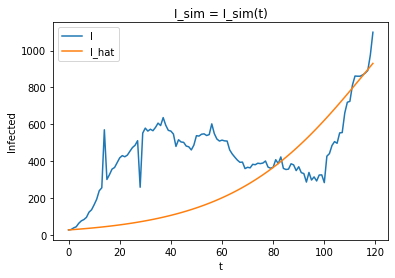

In [19]:
# Visualize the best fit
alpha, beta, _, N_max = omegas[min_J]
S, I_hat, R = SIR_simulation((alpha, beta, N_max), return_all=True)
plt.figure()
plt.plot(I, label="I")
plt.plot(I_hat, label="I_hat")
plt.xlabel("t")
plt.ylabel("Infected")
plt.title("I_sim = I_sim(t)")

plt.legend()
plt.show()

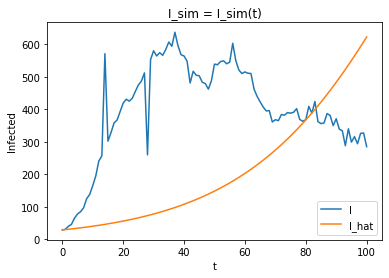

In [20]:
# Sanity Check: T_max = 100
alpha, beta, _, N_max = omegas[min_J]
T_max = 100
I = np.zeros(T_max + 1)

for t in range(0, T_max + 1):
    I[t] = accumulated_cases[t + t0 + 7] - accumulated_cases[t + t0 -7]

S, I_hat, R = SIR_simulation((alpha, beta, N_max), return_all=True)
plt.figure()
plt.plot(I, label="I")
plt.plot(I_hat, label="I_hat")
plt.xlabel("t")
plt.ylabel("Infected")
plt.title("I_sim = I_sim(t)")

plt.legend()
plt.show()